In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import time

depth = 2
module_path = os.path.abspath('.')
sys.path.append(module_path)
for d in xrange(depth):
    module_path = os.path.abspath(os.path.join(module_path, '..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

# from python_bittrex.bittrex.bittrex import Bittrex

In [4]:
% matplotlib inline
from matplotlib import pylab as pl

import seaborn as sns
import pandas as pd

In [5]:
# define paths
base_path = os.path.join(os.path.expanduser('~'), 'freqtrade')
data_path = os.path.join(base_path, 'ml_dev', 'data')

In [377]:
import pandas as pd

df = pd.read_csv(os.path.join(data_path, 'master.csv'))

In [378]:
print df.shape

(3299, 70)


In [379]:
# delete the buy and buy price columns
df = df.drop('buy', axis=1)
df = df.drop('buy_price', axis=1)

In [380]:
# delete the date column
df = df.drop('date', axis=1)

In [381]:
print df.shape
print list(df.columns.values)

(3299, 67)
['close', 'high', 'low', 'open', 'volume', 'sar', 'adx', 'fastd', 'fastk', 'blower', 'sma', 'tema', 'mfi', 'cci', 'rsi', 'mom', 'ema5', 'ema10', 'ema50', 'ema100', 'ao', 'macd', 'macdsignal', 'macdhist', 'natr', 'obv', 'rocp', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI', 'CDLENGULFING', 'CDLHAMMER', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'percent_change']


In [382]:
data = df.as_matrix()

In [392]:
x = data[:, :-1]
y = data[:, -1]

In [393]:
print x.shape
print y.shape

(3299, 66)
(3299,)


In [385]:
import numpy as np

# create categorical version of y
y_cat = np.copy(y)
y_cat[y_cat == 0] = 0
y_cat[y_cat > 0] = 1
y_cat[y_cat < 0] = -1

In [386]:
## apply log scaling to one-sided heavy tailed distributions (makes most sense for ratios)
# x[:, 7:13] = np.log(np.clip(x[:, 7:13], 1e-4, np.inf))

In [387]:
# x[:, -1] = np.log(np.clip(x[:, -1], 1e-4, np.inf))

In [395]:
from sklearn.preprocessing import robust_scale, quantile_transform, StandardScaler
from sklearn import preprocessing

# x_robust = quantile_transform(x[:, 7:], random_state=0, n_quantiles=4, axis=0, output_distribution='normal')
# x = robust_scale(x)
x = preprocessing.scale(x)

In [397]:
print np.mean(x, axis=0)

[  1.86089398e-15   1.86089398e-15   6.20297993e-16   1.10275199e-15
   0.00000000e+00   6.20297993e-16   3.66148121e-17  -2.11073623e-16
  -7.32296242e-17  -1.65412798e-15   5.51375994e-16  -4.82453995e-16
  -3.72609558e-16   0.00000000e+00   2.00304560e-16   3.23071871e-18
  -2.34334797e-15   5.51375994e-16   6.89219992e-16   0.00000000e+00
  -4.30762495e-18   6.46143743e-18  -8.61524990e-18   5.78837103e-18
  -1.29228749e-17   1.03382999e-16  -8.61524990e-18   0.00000000e+00
   6.46143743e-18   5.38453119e-18   0.00000000e+00   3.44609996e-17
   0.00000000e+00  -8.61524990e-18  -1.29228749e-17   1.07690624e-18
   0.00000000e+00   3.01533747e-17  -2.90764684e-17   4.41531558e-17
   1.66920467e-17  -1.72304998e-17   0.00000000e+00  -2.15381248e-17
   2.15381248e-17   4.30762495e-18   2.58457497e-17   3.01533747e-17
   6.46143743e-17  -1.72304998e-17   2.36919372e-17  -2.79995622e-17
  -2.15381248e-17   9.04601240e-17  -4.30762495e-18  -6.67681867e-17
  -2.58457497e-17   5.59991244e-17

In [16]:
# put data in to df for visualization
features = [
#     'price', 'ask', 'bid', 'high', 'low', 'last', 'prev_day', 
    'base_vol', 'open_buy_orders', 'open_sell_orders', 
    'ratio5', 'ratio10', 'ratio25', 
    'change5', 'change10', 'change25', 
    'stv5', 'stv10', 'stv25', 'b_a_spread', 
    'smart_price', 'spi'
]
df = pd.DataFrame()
for f in range(len(features)):
    df[features[f]] = x[:, f]
df['target_categorical'] = y_cat

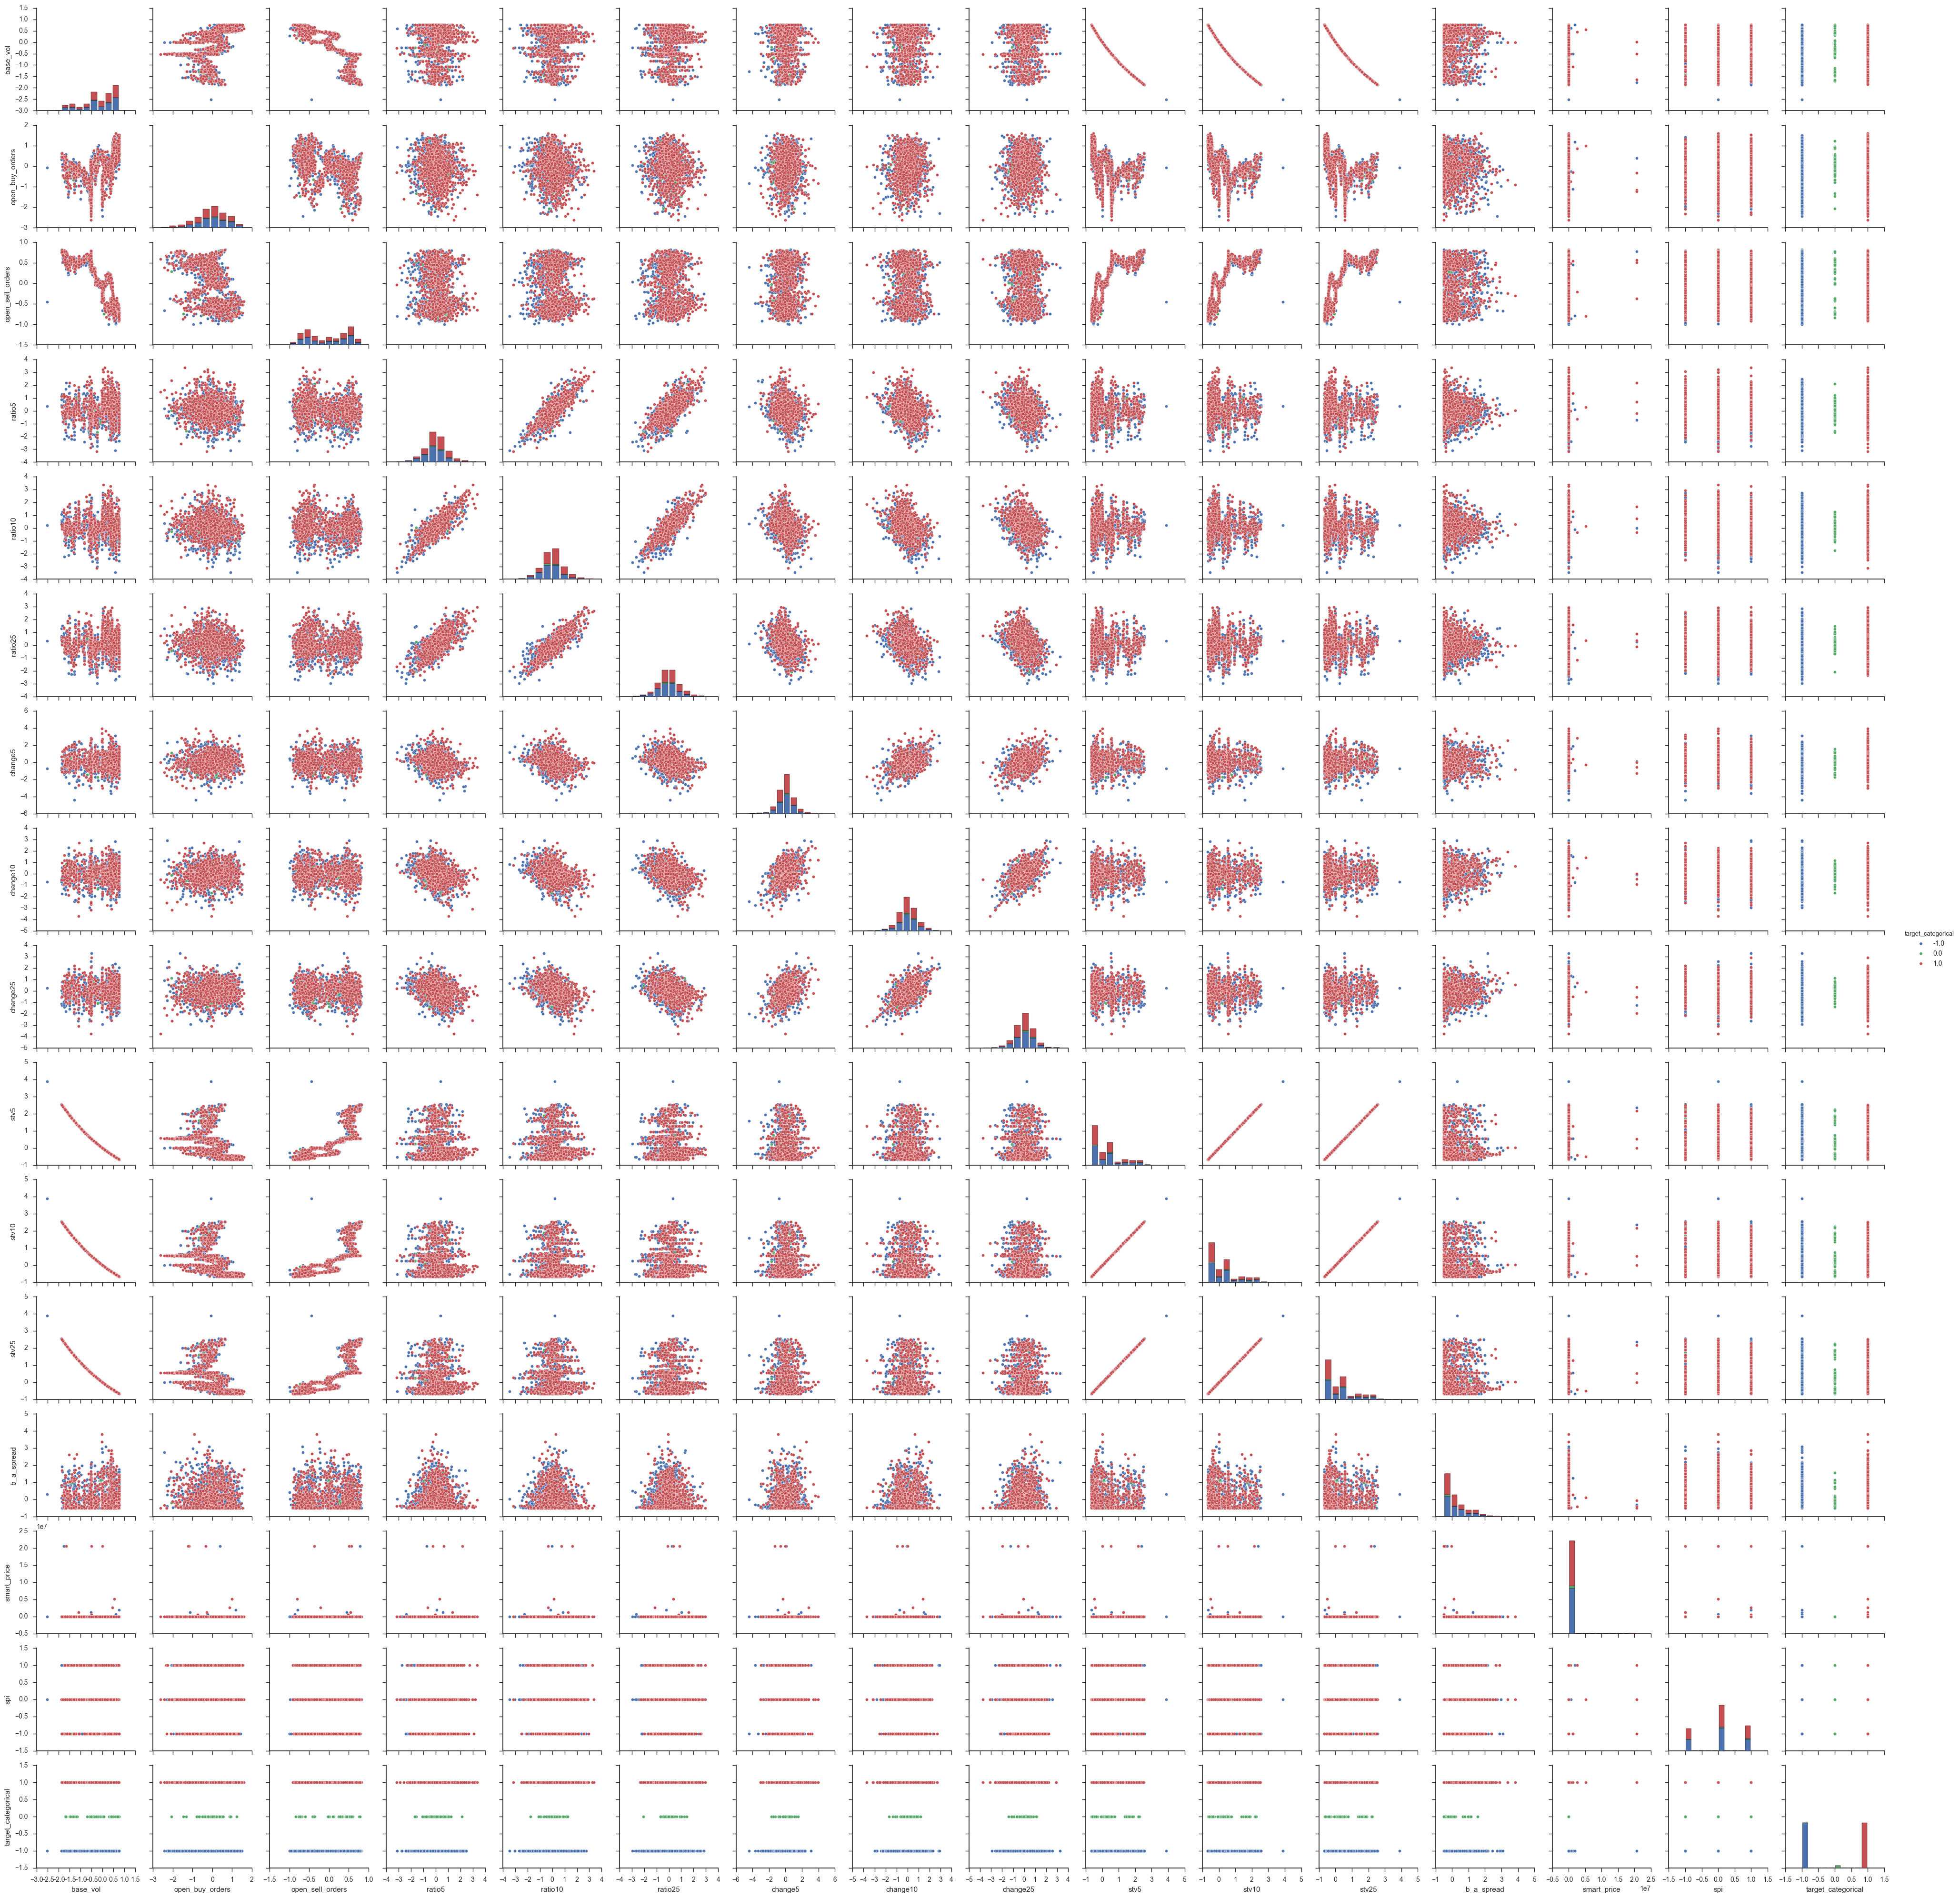

In [17]:
# visualize pairplot
sns.set(style="ticks")
sns.pairplot(df, hue="target_categorical") 

In [34]:
# first create model that predicts if there will be change

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# shuffle data and perfrom train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y_cat, test_size=1 / 3., shuffle=True)

In [33]:
down = np.sum(y_train == -1)
no_change = np.sum(y_train == 0)
up = np.sum(y_train == 1)
total = y_train.shape[0]

print down
print no_change
print up
print total

1006
192
1001
2199


In [34]:
down_weight = 1 - down / float(total)
no_weight = 1 - no_change / float(total)
up_weight = 1 - up / float(total)

In [35]:
sample_weights = np.zeros((y_train.shape[0]))
sample_weights[y_train == -1] = down_weight
sample_weights[y_train == 0] = no_weight
sample_weights[y_train == 1] = up_weight

In [62]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

model = GradientBoostingClassifier(learning_rate=0.02, subsample=1, n_estimators=100, max_depth=2)
# model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train, sample_weight=sample_weights)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1, verbose=0,
              warm_start=False)

In [63]:
t0 = time.time()
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
print('inference time: {}'.format(time.time() - t0))
print('score: {}'.format(score))

inference time: 0.0114130973816
score: 0.55


In [64]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions)

array([[286,   2, 238],
       [ 46,   0,  50],
       [159,   0, 319]])

In [43]:
# print 169 / float(121 + 169)
print 148 / float(148 + 94)

0.611570247934


In [177]:
y_sign = np.sign(y)
y_log = np.log(np.clip(np.abs(y) * 1000, 1e-6, np.inf))
y_log *= y_sign

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# shuffle data and perfrom train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1 / 3., shuffle=True)

In [191]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

In [192]:
model = GradientBoostingRegressor(loss='ls', learning_rate=0.01, subsample=0.5, n_estimators=500)
# model = RandomForestRegressor(criterion='mae')  # 'mse'
# model = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [193]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=0.5, verbose=0, warm_start=False)

In [194]:
t0 = time.time()
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
print('inference time: {}'.format(time.time() - t0))
print('score: {}'.format(score))

inference time: 0.0326569080353
score: 0.105353678988


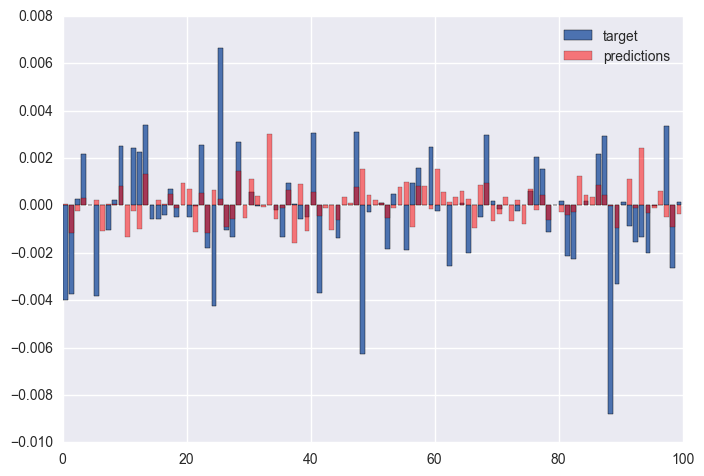

In [195]:
# pl.figure()
# pl.bar(np.arange(y_test.shape[0]), y_test, label='target')
# pl.bar(np.arange(y_test.shape[0]), predictions, label='predictions', c='red')
# pl.legend()
# # pl.axis([])
# pl.show()

pl.figure()
n_examples = 100
pl.bar(np.arange(n_examples), y_test[:n_examples], label='target')
pl.bar(np.arange(n_examples), predictions[:n_examples], label='predictions', color='red', alpha=0.5)
pl.legend()
# pl.axis([])
pl.show()

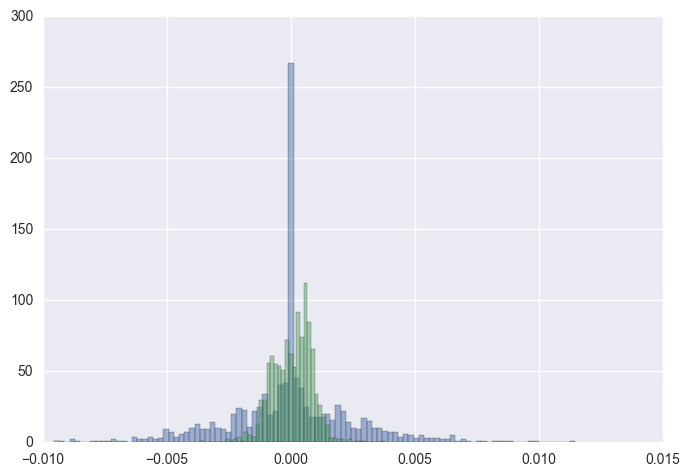

In [196]:
pl.hist(y_test, 100, alpha=0.5);
pl.hist(predictions, 50, alpha=0.5);

In [152]:
y_sign = np.sign(y_test)
y_log = np.log(np.clip(np.abs(y_test), 1e-6, np.inf))
y_log *= y_sign

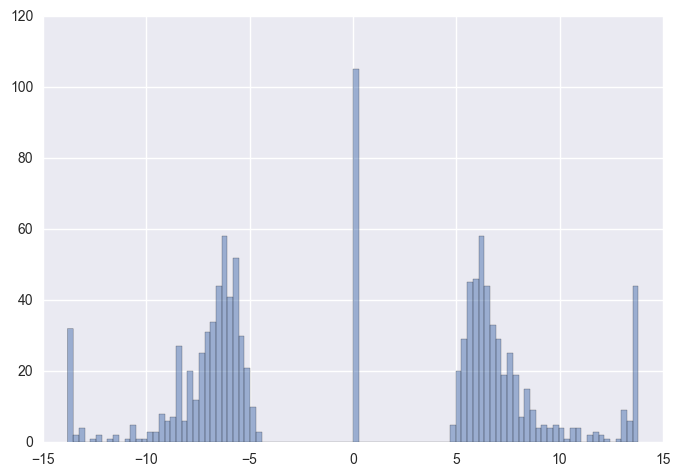

In [153]:
pl.hist(y_log, 100, alpha=0.5);

In [236]:
def buy(pred, fee=0.0025):
    
    buy = False
#     print pred
    if pred == 1:
        buy = True
        
    return buy

In [241]:
def calc_profit(y_pred, y_true, fee=0.0025):
    
    profit = 0
    for trade in range(len(y_pred)):
        
        b = buy(y_pred[trade])
        if b:
            profit += y_true[trade] - fee
#             print profit
            
    return profit

In [140]:
0.25 /100.

0.0025

In [243]:
prop_profitable = np.sum(y > 0.0025) / float(len(y))
print prop_profitable
print 1 / prop_profitable

0.13701121552
7.29867256637


In [201]:
import numpy as np

# create categorical version of y
y_cat = np.copy(y)
y_cat[y_cat > 0.0025] = 1
y_cat[y_cat <= 0.0025] = 0

In [369]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
pca.fit(x)
x = pca.transform(x)

In [398]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# shuffle data and perfrom train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1 / 3., shuffle=True, random_state=0)

In [399]:
# create categorical version of y
y_train_cat = np.copy(y_train)
y_train_cat[y_train > 0.0025] = 1
y_train_cat[y_train <= 0.0025] = 0
y_test_cat = np.copy(y_test)
y_test_cat[y_test > 0.0025] = 1
y_test_cat[y_test <= 0.0025] = 0

In [400]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train_cat)
print(sorted(Counter(y_resampled).items()))

[(0.0, 1896), (1.0, 1896)]


In [413]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import svm

# model = GradientBoostingClassifier(learning_rate=0.02, subsample=1, n_estimators=500, max_depth=2)
# model = svm.SVC(kernel='rbf', class_weight={0: 1, 1: 1})
model = RandomForestClassifier(n_estimators=100, class_weight={0: 1, 1: 1})
model.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [414]:
t0 = time.time()
predictions = model.predict(X_test)
score = model.score(X_test, y_test_cat)
print('inference time: {}'.format(time.time() - t0))
print('score: {}'.format(score))

inference time: 0.0532660484314
score: 0.855454545455


In [415]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_cat, predictions)

array([[921,  30],
       [129,  20]])

In [416]:
calc_profit(predictions, y_test)

-0.022617387039539295

In [20]:
# next create model that regresses change

In [21]:
y_change_only = y[y != 0]
x_change_only = x[y != 0]

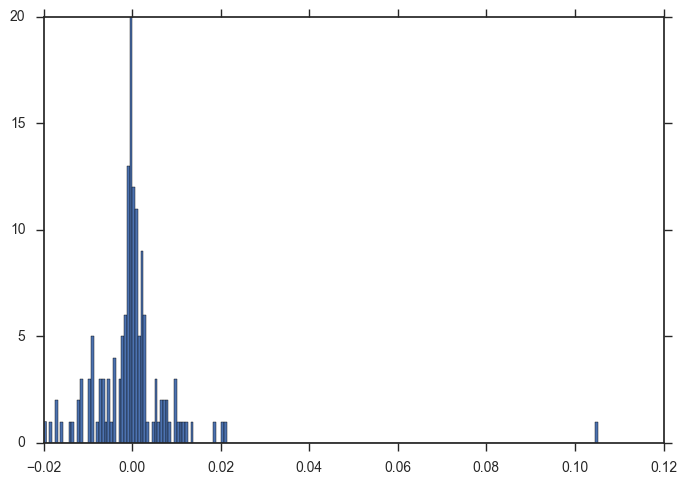

In [22]:
pl.hist(y_change_only, 200);

In [47]:
y_sign = np.sign(y_change_only)
y_change_only /= np.max(np.abs(y_change_only))
y_change_only *= 100
y_change_only = np.log(np.clip(np.abs(y_change_only), 1e-6, np.inf))
y_change_only *= y_sign
y_change_only /= np.max(y_change_only)

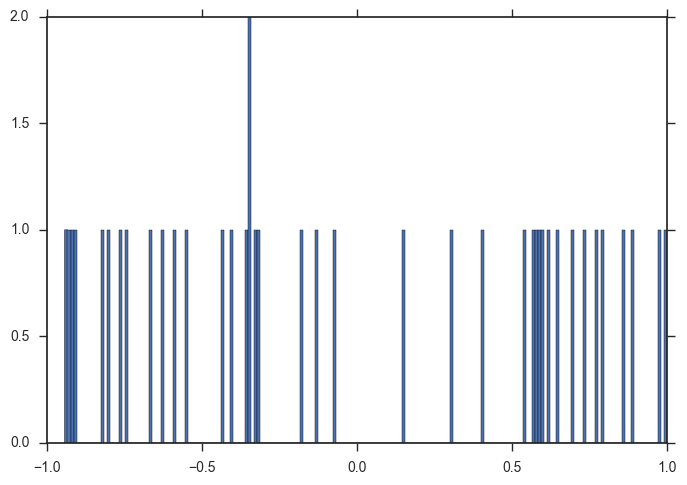

In [48]:
pl.hist(y_change_only, 200);

In [23]:
below = np.sum(y_change_only > 0)
above = np.sum(y_change_only < 0)

In [24]:
print np.minimum(below, above)

73


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


# shuffle data and perfrom train-test split
X_train, X_test, y_train, y_test = train_test_split(x_change_only, y_change_only, test_size=0.33, shuffle=True)

In [26]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

In [27]:
model = GradientBoostingRegressor(loss='huber', learning_rate=0.1, subsample=0.5, n_estimators=500)
# model = RandomForestRegressor(criterion='mse')
# model = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [28]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=0.5, verbose=0,
             warm_start=False)

In [29]:
import time

In [30]:
t0 = time.time()
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
print('inference time: {}'.format(time.time() - t0))
print('score: {}'.format(score))

inference time: 0.00284504890442
score: -0.377563865175


ValueError: incompatible sizes: argument 'height' must be length 100 or scalar

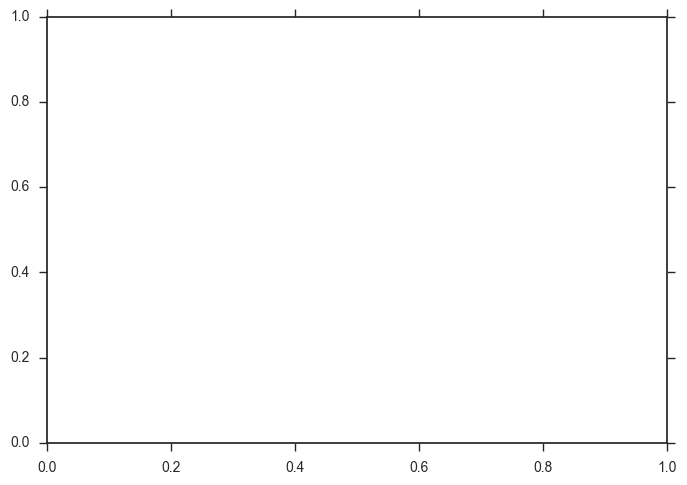

In [31]:
# pl.figure()
# pl.bar(np.arange(y_test.shape[0]), y_test, label='target')
# pl.bar(np.arange(y_test.shape[0]), predictions, label='predictions', c='red')
# pl.legend()
# # pl.axis([])
# pl.show()

pl.figure()
n_examples = 100
pl.bar(np.arange(n_examples), y_test[:n_examples], label='target')
pl.bar(np.arange(n_examples), predictions[:n_examples], label='predictions', color='red', alpha=0.5)
pl.legend()
# pl.axis([])
pl.show()

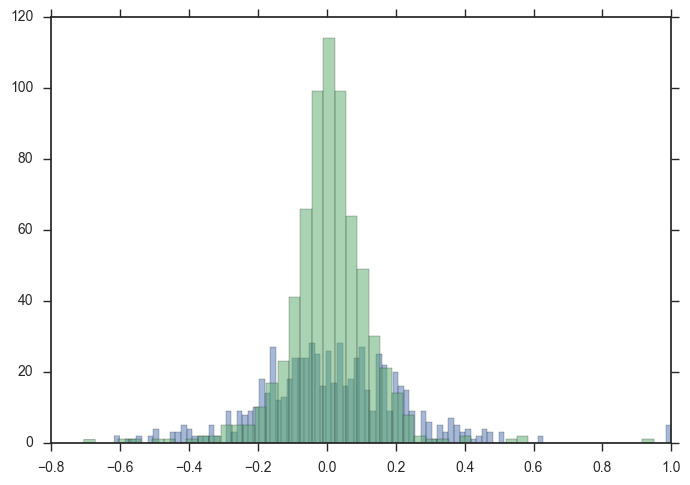

In [542]:
pl.hist(y_test, 100, alpha=0.5);
pl.hist(predictions, 50, alpha=0.5);

In [543]:
y_gain = y[y > 0]
x_gain = x[y > 0]

In [544]:
# shuffle data and perfrom train-test split
X_train, X_test, y_train, y_test = train_test_split(x_gain, y_gain, test_size=0.33, shuffle=True)

In [545]:
model = GradientBoostingRegressor(loss='huber', learning_rate=0.1, subsample=0.5, n_estimators=500)
# model = RandomForestRegressor(criterion='mse')
# model = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [546]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=0.5, verbose=0,
             warm_start=False)

In [547]:
t0 = time.time()
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
print('inference time: {}'.format(time.time() - t0))
print('score: {}'.format(score))

inference time: 0.00734090805054
score: 0.00386887828238


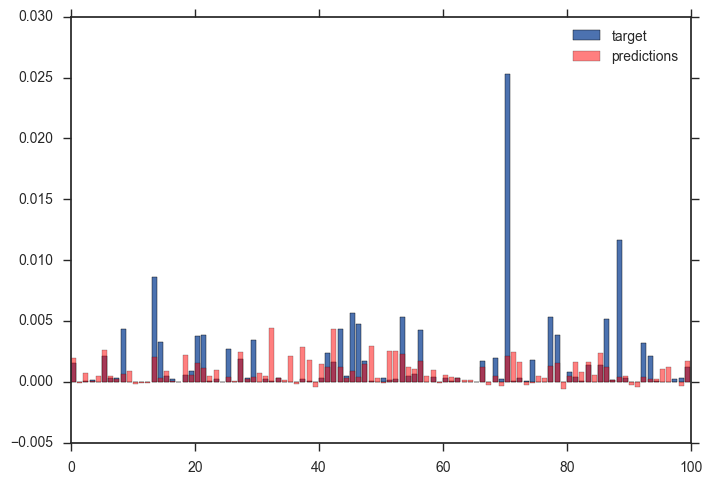

In [548]:
# pl.figure()
# pl.bar(np.arange(y_test.shape[0]), y_test, label='target')
# pl.bar(np.arange(y_test.shape[0]), predictions, label='predictions', c='red')
# pl.legend()
# # pl.axis([])
# pl.show()

pl.figure()
n_examples = 100
pl.bar(np.arange(n_examples), y_test[:n_examples], label='target')
pl.bar(np.arange(n_examples), predictions[:n_examples], label='predictions', color='red', alpha=0.5)
pl.legend()
# pl.axis([])
pl.show()